In [1]:
!pip install git+https://github.com/lindermanlab/ssm#egg=ssm


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/lindermanlab/ssm to /tmp/pip-install-2orivia6/ssm_3de1a250cac8418ca038e2c4f9aac2ad
  Running command git clone --filter=blob:none --quiet https://github.com/lindermanlab/ssm /tmp/pip-install-2orivia6/ssm_3de1a250cac8418ca038e2c4f9aac2ad
  Resolved https://github.com/lindermanlab/ssm to commit 6c856ad3967941d176eb348bcd490cfaaa08ba60
  Preparing metadata (setup.py) ... done
  Created wheel for ssm: filename=ssm-0.0.1-cp39-cp39-linux_x86_64.whl size=547180 sha256=21c727dc969b1577cfc0d27feec80e08fce871764771b08877b9e010b2f614f4
  Stored in directory: /tmp/pip-ephem-wheel-cache-vi48863p/wheels/1e/01/67/020db7d7ed3cecc27c6e292af0f29035bddc96e5b4d97548e9
Successfully built ssm


In [1]:
import numpy as np
import numpy.random as npr

import matplotlib.pyplot as plt
from tqdm.auto import trange 

import ssm
from ssm.messages import hmm_sample

# Sample synthetic data

In [2]:
num_factors = 3
num_states = 2
emission_dim = 10

hypers = dict(num_factors=num_factors,
              num_states=num_states,
              emission_dim=emission_dim)

num_timesteps = 1000

initial_dist = np.ones((num_factors, num_states)) / num_states
transition_matrix = 0.9 * np.eye(num_states) + 0.1 * np.roll(np.eye(num_states), 1, axis=1)
transition_matrices = np.tile(transition_matrix, (num_factors, 1, 1))

means = 3 * npr.randn(num_factors, num_states, emission_dim)
# means = np.zeros((num_factors, num_states, emission_dim))
# means[1] = npr.gamma(10.0, 1.0, size=(num_states, emission_dim))
variances = 0.1 * np.ones((num_factors, num_states, emission_dim))

params = dict(initial_dist=initial_dist,
              transition_matrices=transition_matrices,
              means=means,
              variances=variances)

true_states = np.zeros((num_timesteps, num_factors), dtype=int)
emissions = np.zeros((num_timesteps, emission_dim))
expec_emissions = np.zeros((num_timesteps, emission_dim))

npr.seed(0)
for t in range(num_timesteps):
    for h in range(num_factors):
        if t > 0:
            true_states[t, h] = \
              npr.choice(num_states, p=transition_matrices[h, true_states[t-1, h]])
        
    # mean = np.zeros(emission_dim)
    # for h in range(num_factors):      
    #     mean += means[h, states[t,h], :]
    expec_emissions[t] = np.sum(means[np.arange(num_factors), true_states[t]], axis=0)
    var = np.sum(variances[np.arange(num_factors), true_states[t]], axis=0)
    emissions[t] = expec_emissions[t] + np.sqrt(var) * npr.randn(emission_dim)

(300.0, 400.0)

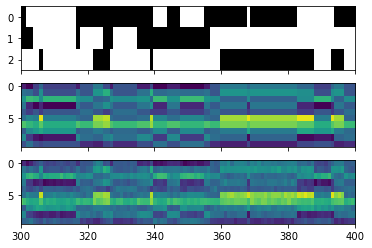

In [3]:
fig, axs = plt.subplots(3, 1, sharex=True)
axs[0].imshow(true_states.T, aspect="auto", interpolation="none", cmap="Greys")
axs[1].imshow(expec_emissions.T, aspect="auto", interpolation="none")
axs[2].imshow(emissions.T, aspect="auto", interpolation="none")

# axs[3].imshow(mean, aspect="auto", interpolation="none")

plt.xlim(300, 400)

# Inference via Gibbs sampling

Let $z_{t,h} \in \{1,\ldots,K\}$ be the state of factor $h$ at time $t$. The emissions are,

\begin{align}
x_{t,n} \sim N(\sum_h \mu_{h,z_{t,h},n}, \sum_h \sigma_{h,z_{t,h},n}^2)
\end{align}


In [4]:
from scipy.stats import norm

def _gibbs_sample_states(h, states, emissions, params, hypers):
    """Sample sequence of states for factor h given the other factors.
    """
    num_factors = hypers["num_factors"]
    num_states = hypers["num_states"]
    num_timesteps = states.shape[0]
    means = params["means"]
    variances = params["variances"]

    lls = np.zeros((num_timesteps, num_states))
    tmp_states = states.copy()
    for k in range(num_states):
        tmp_states[:, h] = k
        expec_emissions = np.zeros_like(emissions)
        var_emissions = np.zeros_like(emissions)
        for j in range(num_factors):
            expec_emissions += means[j, tmp_states[:, j], :]
            var_emissions += variances[j, tmp_states[:, j], :]
      
        lls[:, k] = norm(expec_emissions, np.sqrt(var_emissions)).logpdf(emissions).sum(axis=1)

    return hmm_sample(params["initial_dist"][h],
                             params["transition_matrices"][h][None, :, :],
                             lls)  

def gibbs(states, emissions, params, hypers, num_iters=100):
    num_factors = hypers["num_factors"]

    samples = []
    for itr in trange(num_iters):
        states = states.copy()
        for h in range(num_factors):
            states[:, h] = _gibbs_sample_states(h, states, emissions, params, hypers)

        # TODO:
        # params = _gibbs_sample_params(states, emissions, params)

        samples.append(states)
    
    return samples


npr.seed(123)
initial_states = np.zeros((num_timesteps, num_factors), dtype=int)
samples = gibbs(initial_states, emissions, params, hypers, num_iters=100)

  0%|          | 0/100 [00:00<?, ?it/s]

(300.0, 400.0)

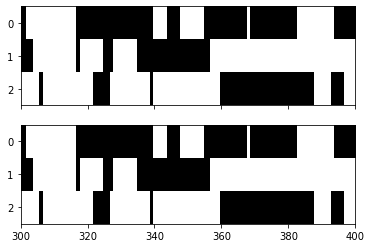

In [5]:
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].imshow(true_states.T, aspect="auto", interpolation="none", cmap="Greys")
axs[1].imshow(samples[-1].T, aspect="auto", interpolation="none", cmap="Greys")
plt.xlim(300, 400)

In [10]:
samples

[array([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [1, 0, 0],
        [1, 0, 0],
        [0, 0, 0]]), array([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [1, 0, 0],
        [1, 0, 0],
        [0, 0, 0]]), array([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [1, 0, 0],
        [1, 0, 0],
        [0, 0, 0]]), array([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [1, 0, 0],
        [1, 0, 0],
        [0, 0, 0]]), array([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [1, 0, 0],
        [1, 0, 0],
        [0, 0, 0]]), array([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [1, 0, 0],
        [1, 0, 0],
        [0, 0, 0]]), array([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [1, 0, 0],
        [1, 0, 0],
        [0, 0, 0]]), array([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [1, 0, 0],
        [1, 0, 